In [2]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA

from asteria.simulation import Simulation
from plthelper import *
from bootstapping import *
from scipy.stats import kstest
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [3]:
add_wls = True
detector_scope = "Gen2"

samples = 10000000

distance = 15*u.kpc
frequency =80*u.Hz # 50 Hz and 400 Hz, in steps of 50 Hz
amplitude = 0.2 # 1% and 50% in log steps (1%, 2%, 5%, 10%, 20%, 50%)
time_start = 150*u.ms
time_end = 300*u.ms
position = "center"

sim_dt = 1 * u.ms
res_dt = 1 * u.ms
time_win = [0, 0.35] * u.s # time independent
freq_res = 1 * u.Hz 
freq_win = [75, 1E6] * u.Hz # freq independent
hanning = False

temp_para = {"frequency": frequency, 
             "amplitude": amplitude, #in percent of max value
             "time_start": time_start,
             "time_end": time_end,
             "position": position}

mode = "FFT"

fft_para = {"time_res": res_dt, 
             "time_win": time_win,
             "freq_res": time_start,
             "freq_win": freq_win,
             "hanning": hanning}


ana_para = {"distance": distance,
            "res_dt": res_dt,
            "temp_para": temp_para,
            "mode": mode,
            "ft_para": fft_para}

model = {'name': 'Sukhbold_2015',
         'param':{
             'progenitor_mass': 27*u.Msun, 
             'eos': 'LS220'}
        }

sim = Simulation(model=model,
                 distance=10*u.kpc, 
                 res_dt=res_dt,
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.000*u.s, tmax=1*u.s, dt=sim_dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 detector_scope = detector_scope,
                 add_wls = add_wls)
sim.run()

In [3]:
boot = Bootstrapping(sim, ana_para=ana_para, verbose=True)
boot.load_data("./files/bootstrapping/GENERATE_model_{}_{:.0f}_mode_{}_samples_{:1.0e}_distance_{:.0f}kpc.npz".format(model["name"], model["param"]["progenitor_mass"].value, mode, samples, distance.value))
#boot.generate_data(samples=samples)

BOOTSTRAPPING -- TRIALS 1000 -- REPETITIONS 500
Detector: ic86


100%|██████████| 500/500 [00:00<00:00, 561.94it/s]


Detector: gen2


100%|██████████| 500/500 [00:00<00:00, 515.35it/s]


Detector: wls


100%|██████████| 500/500 [00:00<00:00, 556.14it/s]


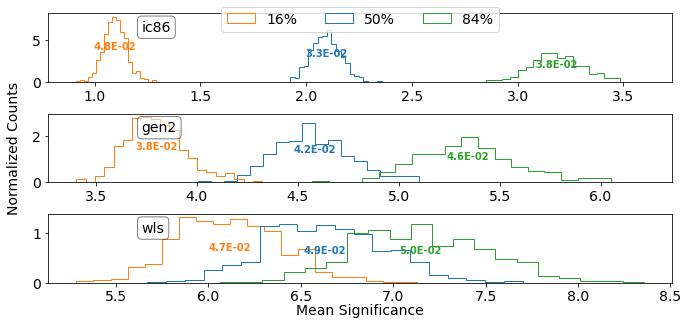

BOOTSTRAPPING -- TRIALS 10000 -- REPETITIONS 500
Detector: ic86


100%|██████████| 500/500 [00:02<00:00, 236.18it/s]


Detector: gen2


100%|██████████| 500/500 [00:02<00:00, 207.04it/s]


Detector: wls


100%|██████████| 500/500 [00:02<00:00, 210.21it/s]


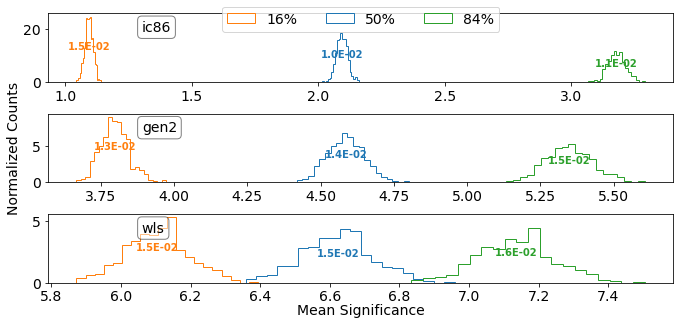

BOOTSTRAPPING -- TRIALS 100000 -- REPETITIONS 500
Detector: ic86


100%|██████████| 500/500 [00:14<00:00, 34.82it/s]


Detector: gen2


100%|██████████| 500/500 [00:17<00:00, 27.92it/s]


Detector: wls


100%|██████████| 500/500 [00:18<00:00, 27.35it/s]


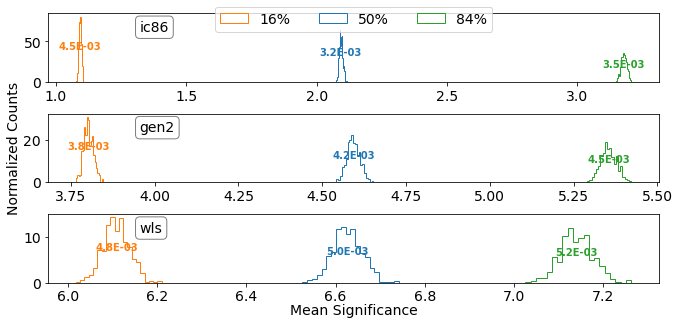

In [5]:
trials_range = [1000, 10000, 100000]
repetitions = 500
distribution = "lognorm"

for trials in trials_range:
    boot.run_same(trials=trials, repetitions=repetitions, distribution = distribution)
    fig, ax = plot_bootstrap(boot.zscore)
    fig.savefig("./plots/bootstrapping/SAME_model_{}_{:.0f}_mode_{}_distrib_{}_samples_{:1.0e}_trials_{}_reps_{}_distance_{:.0f}kpc.pdf"
                .format(model["name"], model["param"]["progenitor_mass"].value, mode, distribution, samples, trials, repetitions, distance.value))
    plt.show()

skewnorm
REALDEAL
Detector: ic86


100%|██████████| 500/500 [00:00<00:00, 2000.70it/s]


Detector: gen2


100%|██████████| 500/500 [00:00<00:00, 2131.82it/s]


Detector: wls


100%|██████████| 500/500 [00:00<00:00, 2131.10it/s]


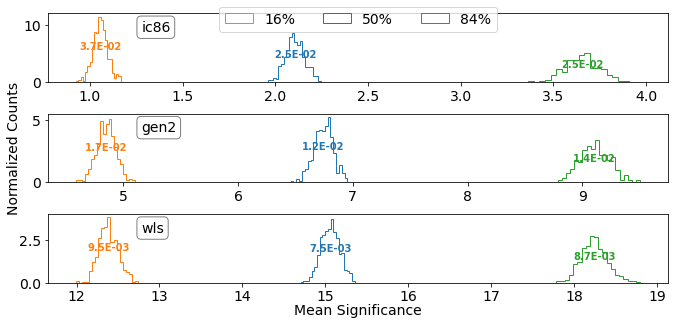

skewnorm
REALDEAL
Detector: ic86


100%|██████████| 500/500 [00:00<00:00, 1378.62it/s]


Detector: gen2


100%|██████████| 500/500 [00:00<00:00, 1400.40it/s]


Detector: wls


100%|██████████| 500/500 [00:00<00:00, 1393.04it/s]


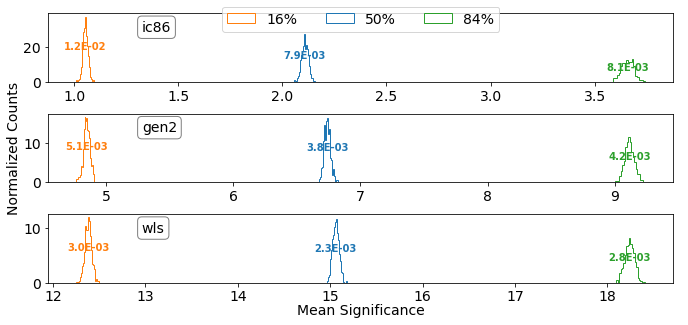

skewnorm
REALDEAL
Detector: ic86


100%|██████████| 500/500 [00:01<00:00, 325.32it/s]


Detector: gen2


100%|██████████| 500/500 [00:01<00:00, 318.04it/s]


Detector: wls


100%|██████████| 500/500 [00:01<00:00, 316.96it/s]


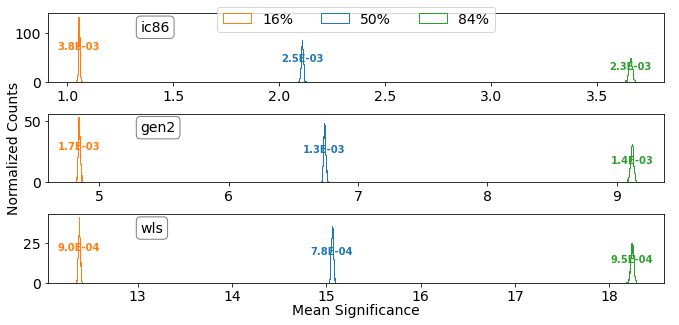

In [7]:
trials_range = [1000, 10000, 100000]
repetitions = 500
distribution = "skewnorm"

for trials in trials_range:
    boot.run_full(trials=trials, repetitions=repetitions, distribution = distribution)
    fig, ax = plot_bootstrap(boot.zscore)
    fig.savefig("./plots/bootstrapping/FULL_model_{}_{:.0f}_mode_{}_distrib_{}_samples_{:1.0e}_trials_{}_reps_{}_distance_{:.0f}kpc.pdf"
                .format(model["name"], model["param"]["progenitor_mass"].value, mode, distribution, samples, trials, repetitions, distance.value))
    plt.show()

In [8]:
from scipy.optimize import minimize
from scipy.stats import loggamma, lognorm, gamma, skewnorm

det = "ic86"
ts = boot.ts

skewnorm_fit = skewnorm(*skewnorm.fit(ts[det]["null"]))
lognorm_fit = lognorm(*lognorm.fit(ts[det]["null"]))


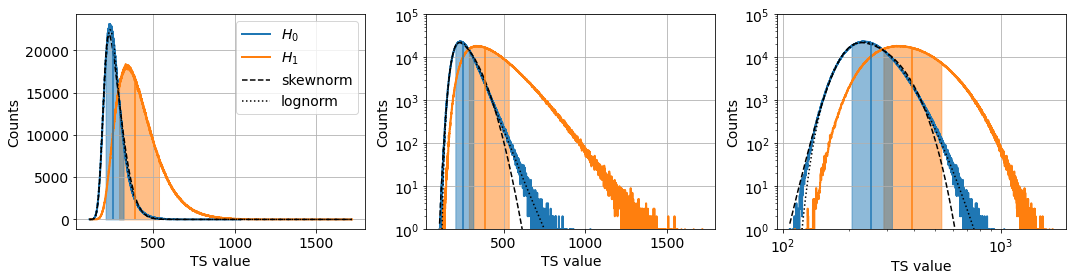

In [36]:
# Plot TS distribution for null and signal hypothesis for gen2

density = False

# get 16, 50, 86% of TS distribution
ps_null = np.percentile(ts[det]["null"], [16, 50, 84])
ps_signal = np.percentile(ts[det]["signal"], [16, 50, 84])

# binning
bins = int(np.sqrt(len(ts[det]["null"])))

# histogram data
y_null, bin_null = np.histogram(ts[det]["null"], bins = bins, density=density)
y_signal, bin_signal = np.histogram(ts[det]["signal"], bins = bins, density=density)

# get x values
x_null, x_signal = (bin_null[1:]+bin_null[:-1])/2, (bin_signal[1:]+bin_signal[:-1])/2

# mask range of 16% and 84% quantiles
mask_null = np.logical_and(x_null > ps_null[0], x_null < ps_null[2])
mask_signal = np.logical_and(x_signal > ps_signal[0], x_signal < ps_signal[2])

# get fitted background distribution
x_fit = np.linspace(np.minimum(x_null[0],x_signal[0]), np.maximum(x_null[-1],x_signal[-1]), 500)
y_skewnorm = skewnorm_fit.pdf(x_fit)
y_lognorm = lognorm_fit.pdf(x_fit)

# bin size of histogram and fit
dx_null = x_null[1]-x_null[0]
dx_fit = x_fit[1]-x_fit[0]

# scaling factor
scaling_skewnorm = (np.sum(y_null)*dx_null)/(np.sum(y_skewnorm)*dx_fit)
scaling_lognorm = (np.sum(y_null)*dx_null)/(np.sum(y_lognorm)*dx_fit)

hi_null = y_null[np.searchsorted(x_null, ps_null, side='left')-1]
hi_signal = y_signal[np.searchsorted(x_signal, ps_signal, side='left')-1]

if density:
    ylim = (1E-7, 1E-2)

else:
    ylim = (1, 1E5)

fig, ax = plt.subplots(1,3, figsize = (15,4))

for i in range(3):
    # plot histogram
    ax[i].step(x_null, y_null, color = 'C0', lw = 2, label = r"$H_0$")
    ax[i].step(x_signal, y_signal, color = 'C1', lw = 2, label = r"$H_1$")

    # plot fit
    ax[i].plot(x_fit, y_skewnorm * scaling_skewnorm, "k--", label = "skewnorm")
    ax[i].plot(x_fit, y_lognorm * scaling_lognorm, "k:", label = "lognorm")

    # plot mean value
    ax[i].vlines(ps_null[1], ymin = 0, ymax = hi_null[1], color = 'C0', ls = '-')
    ax[i].vlines(ps_signal[1], ymin = 0, ymax = hi_signal[1], color = 'C1', ls = '-')

    # shade 16%-84% quantile
    ax[i].fill_between(x = x_signal[mask_signal], y1 = y_signal[mask_signal], color = 'C1', alpha = 0.5)
    ax[i].fill_between(x = x_null[mask_null], y1 = y_null[mask_null], color = 'C0', alpha = 0.5)

    ax[i].set_xlabel("TS value", fontsize = 14)
    ax[i].set_ylabel("Counts", fontsize = 14)
    ax[i].tick_params(labelsize = 14)
    ax[i].grid()

    if i == 1:
        ax[i].set_yscale("log")
        ax[i].set_ylim(ylim)

    elif i == 2:
        ax[i].set_yscale("log")
        ax[i].set_ylim(ylim)
        ax[i].set_xscale("log")

ax[0].legend(fontsize = 14)

plt.tight_layout()
if density:
    plt.savefig("./plots/bootstrapping/TS_model_{}_{:.0f}_mode_{}_samples_{:1.0e}_distance_{:.0f}kpc_norm.pdf"
                .format(model["name"], model["param"]["progenitor_mass"].value, mode, samples, distance.value))
else:
    plt.savefig("./plots/bootstrapping/TS_model_{}_{:.0f}_mode_{}_samples_{:1.0e}_distance_{:.0f}kpc.pdf"
                .format(model["name"], model["param"]["progenitor_mass"].value, mode, samples, distance.value))

In [37]:
# KS test comparing skewnormal and lognormal to data

det = "ic86"
data = ts[det]["null"]

distributions = [skewnorm, lognorm]

for distr in distributions:

    distr_para = distr.fit(data)
    distr_fit = distr(*distr_para)
    ks_stat, ks_pvalue = kstest(data, distr.rvs(distr_para[2], loc = distr_para[0], scale = distr_para[1], size = len(data)))
    print(distr.name, ks_stat, ks_pvalue)


skewnorm 0.6061973 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6404: RuntimeWarning: overflow encountered in exp
  return np.exp(s * random_state.standard_normal(size))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1071: RuntimeWarning: overflow encountered in multiply
  vals = vals * scale + loc


lognorm 0.5007102 0.0


In [254]:
class BrokenPowerLaw():

    def __init__(self) -> None:
        pass

    def _pdf_loss(self, para, args):
        x_hist, y_hist, mode = args
        y_fit = self.pdf(x_hist, para, mode)

        return np.sqrt(np.sum((y_fit-y_hist)**2))

    def fit(self, data, mode = None):
        """Fits distribution to data. Returns the fit parameters of the distribution.

        Args:
            data (np.ndarray or list): Data can be random variable (np.ndarray) or histogram bin and amplitudes (list)
            mode (str or None, optional): For linear fit mode = "lin" or mode = "None". For log10 fit mode = "log". Defaults to None.

        Returns:
            list: fitted parameters of the distribution
        """
        if isinstance(data, np.ndarray):
            y_hist, bin_hist = np.histogram(data, bins = int(np.sqrt(len(data))), density=True)
            x_hist = (bin_hist[1:]+bin_hist[:-1])/2

        elif isinstance(data, list):
            x_hist, y_hist = data

        else:
            raise ValueError("data type is {} but must be np.ndarray or list".format(type(data)))


        x_break = np.log10(x_hist[np.argmax(y_hist)])

        para0 = [1E-2, 1, -1, x_break, 1]

        if mode is None or mode == "lin":
            args = [x_hist, y_hist, mode]

        elif mode == "log":
            args = [x_hist, np.log10(y_hist), mode]            
        
        res = minimize(self._pdf_loss, x0=para0, args=args, method = "Nelder-Mead")
        return res.x


    def pdf(self, x, para, mode = None):
        """Probability density function at x given the parameters of the distribution.

        Args:
            x (np.ndarray): random variable
            para (list): parameters of broken power law
            mode (str or None, optional): For linear fit mode = "lin" or mode = "None". For log10 fit mode = "log". Defaults to None.

            parameters of broken power law
            a: normalization
            g1: spectral index before break
            g2: spectral index after break
            logx0: log10 of the random variable where the break happens
            curve: curvature (smoothness) of the break

        Returns:
            np.ndarray: pdf
        """

        a, g1, g2, logx0, curve = para
        logx = np.log10(x)

        if mode is None or mode == "lin":
            return a * 10**(logx * g1) * (1 + (10 ** logx / 10 ** logx0) ** curve) ** ((g2 - g1) / curve)

        elif mode == "log":
            return a + g1 * logx + (g2 - g1) / curve * np.log10(1 + (10 ** logx / 10 ** logx0) ** curve)